In [44]:
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt

from dslab_virgo_tsi.visualizer import Visualizer
from dslab_virgo_tsi.base import Result, BaseSignals, OutResult, FinalResult
from dslab_virgo_tsi.constants import Constants as Const
from dslab_virgo_tsi.data_utils import load_data, normalize, unnormalize

In [45]:
visualizer = Visualizer()
visualizer.set_figsize()

In [91]:
with open("./results/SMOOTH_MONOTONIC_modeling_result.pkl", "rb") as handle:
    result: Result = pickle.load(handle)
        
base_sig: BaseSignals = result.base_signals
out_res: OutResult = result.out
final_res: FinalResult = result.final

other_res = load_data(Const.DATA_DIR, Const.VIRGO_TSI_FILE, "virgo_tsi")
other_res[Const.PMO6V_OLD] = other_res[Const.PMO6V_OLD].interpolate("nearest")
other_res = other_res[[Const.T, Const.PMO6V_OLD]].dropna()

other_tsi = other_res[Const.PMO6V_OLD].values
other_t = other_res[Const.T].values
other_triplet = (other_t, other_tsi, f"{Const.PMO6V_OLD}_corrected")
other_fourplet = (other_t, other_tsi, f"{Const.PMO6V_OLD}_corrected", False)

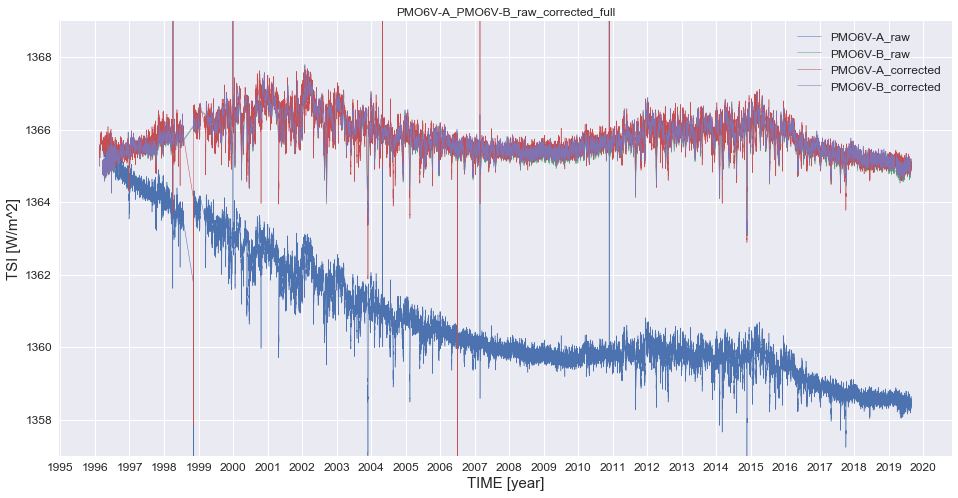

In [84]:
visualizer.plot_signals(
[
    (base_sig.t_a_nn, base_sig.a_nn, f"{Const.A}_raw", False),
    (base_sig.t_b_nn, base_sig.b_nn, f"{Const.B}_raw", False),
    (base_sig.t_a_nn, final_res.a_nn_corrected, f"{Const.A}_corrected", False),
    (base_sig.t_b_nn, final_res.b_nn_corrected, f"{Const.B}_corrected", False),
],
None, f"{Const.A}_{Const.B}_raw_corrected_full", x_ticker=1, y_lim=[1357, 1369],
legend="upper right", x_label=Const.YEAR_UNIT, y_label=Const.TSI_UNIT, max_points=1e5)

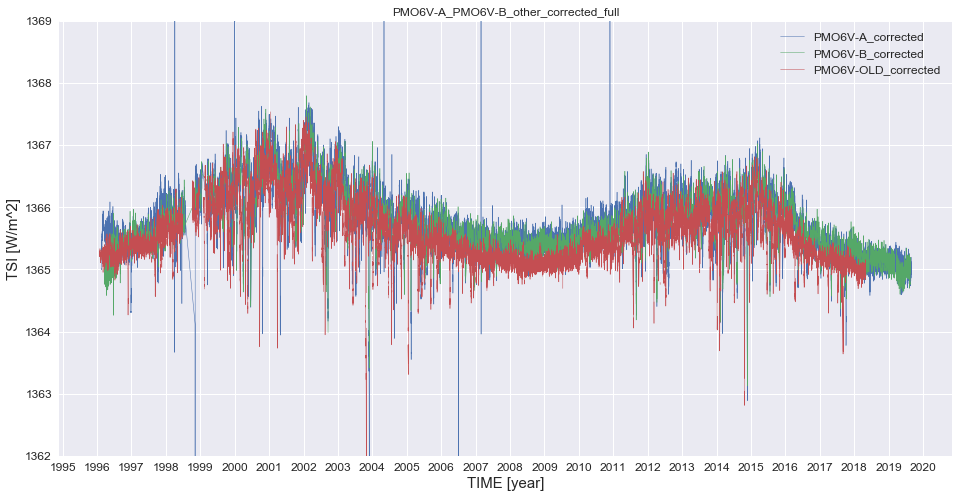

In [5]:
visualizer.plot_signals(
[
    (base_sig.t_a_nn, final_res.a_nn_corrected, f"{Const.A}_corrected", False),
    (base_sig.t_b_nn, final_res.b_nn_corrected, f"{Const.B}_corrected", False),
    other_fourplet
],
None, f"{Const.A}_{Const.B}_other_corrected_full", x_ticker=1, y_lim=[1362, 1369],
legend="upper right", x_label=Const.YEAR_UNIT, y_label=Const.TSI_UNIT)

tau 0.1000100010001
n_lags 6000
t (10000,)
t (10000,)
t (10000,)
t (10000,)
t (10000,)


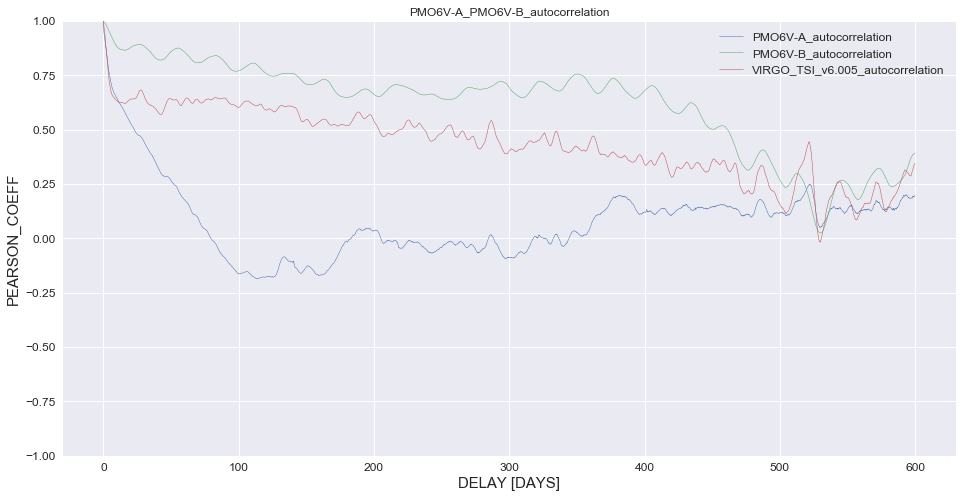

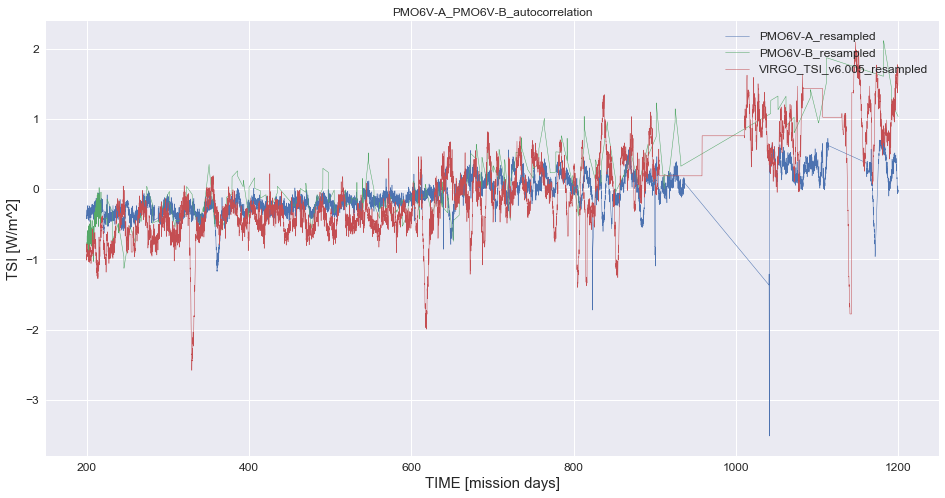

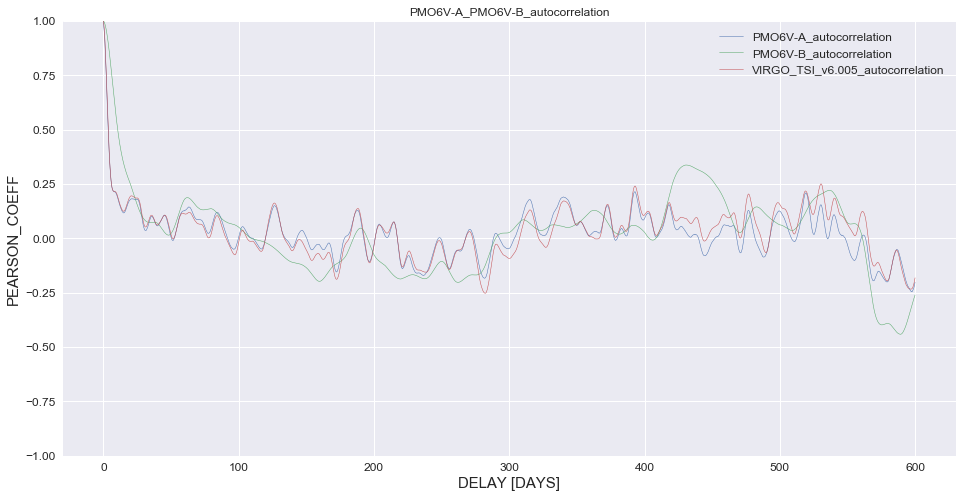

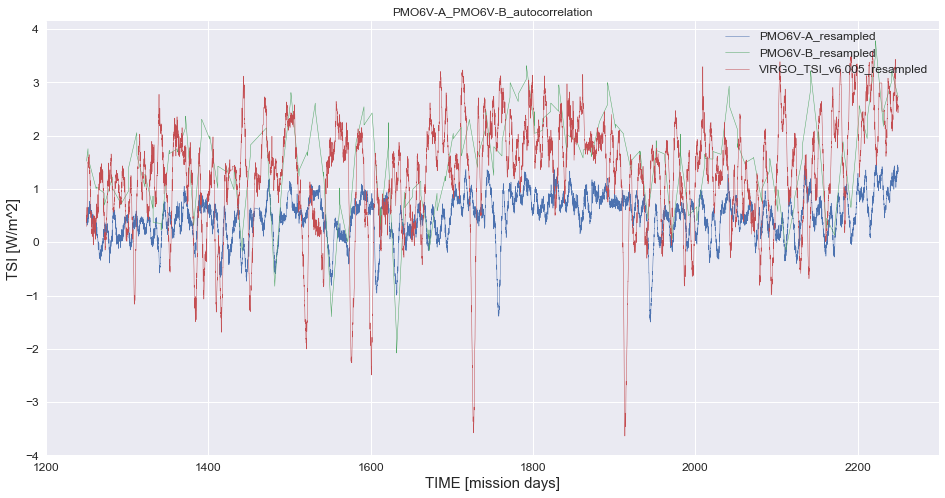

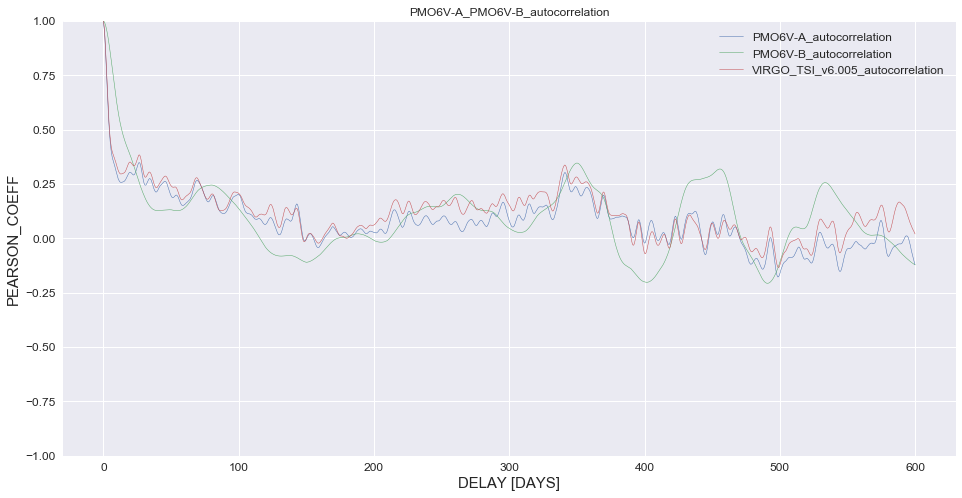

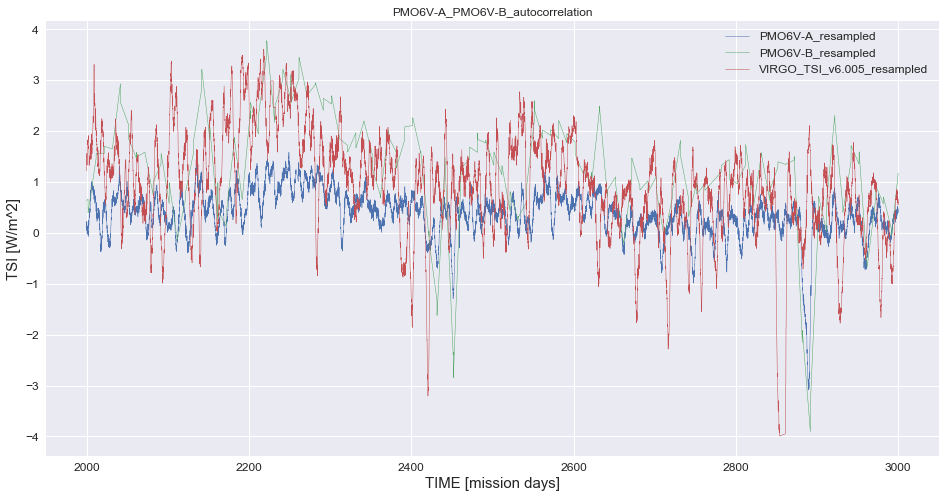

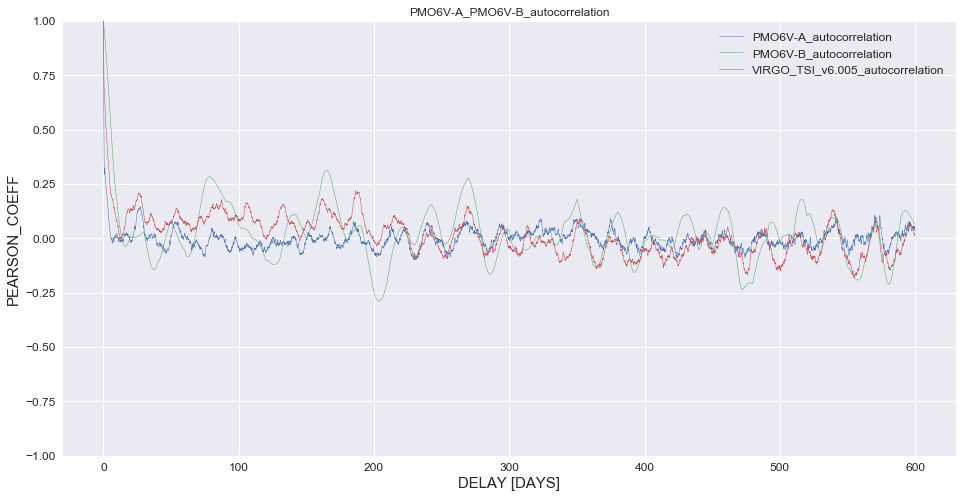

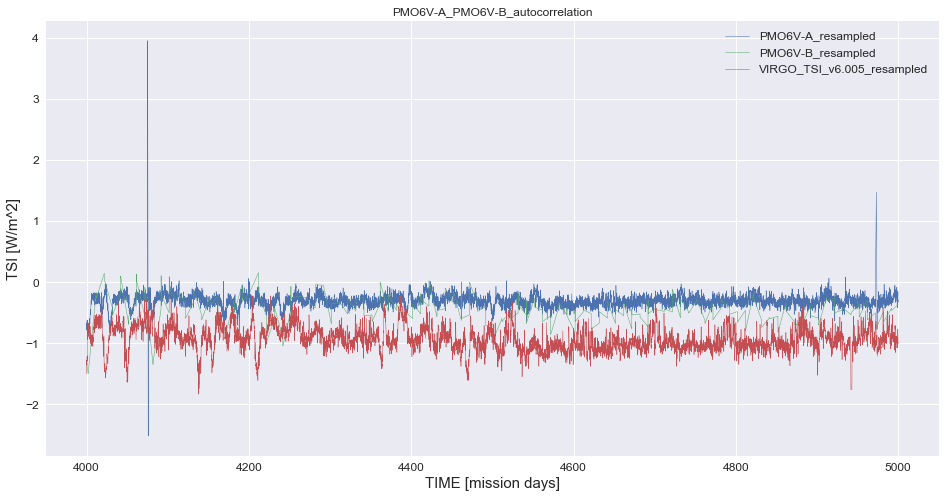

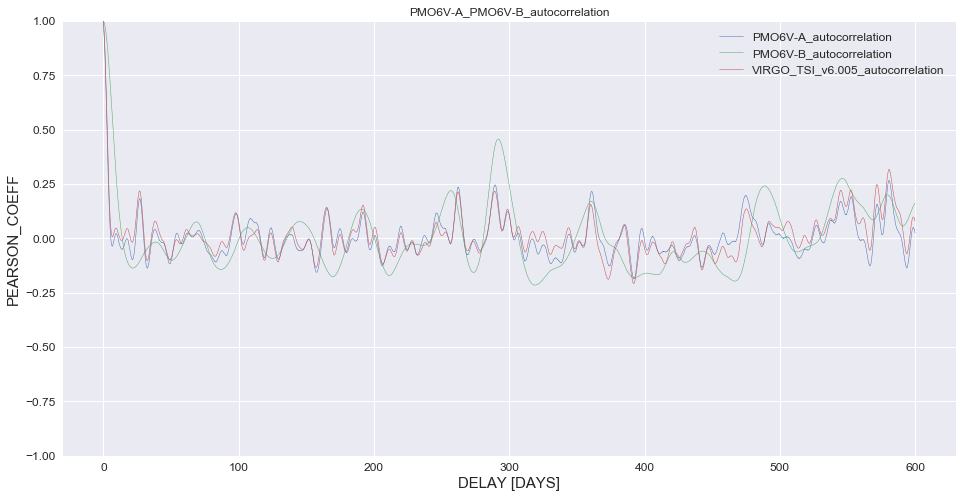

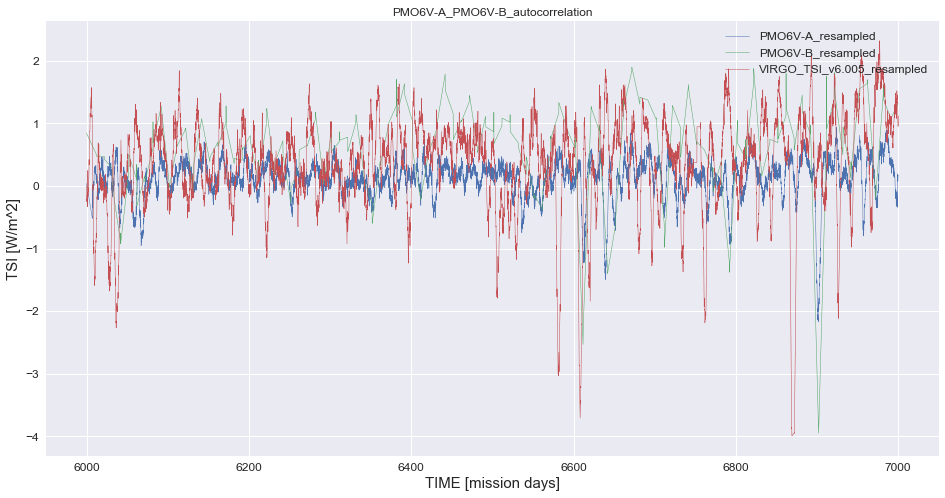

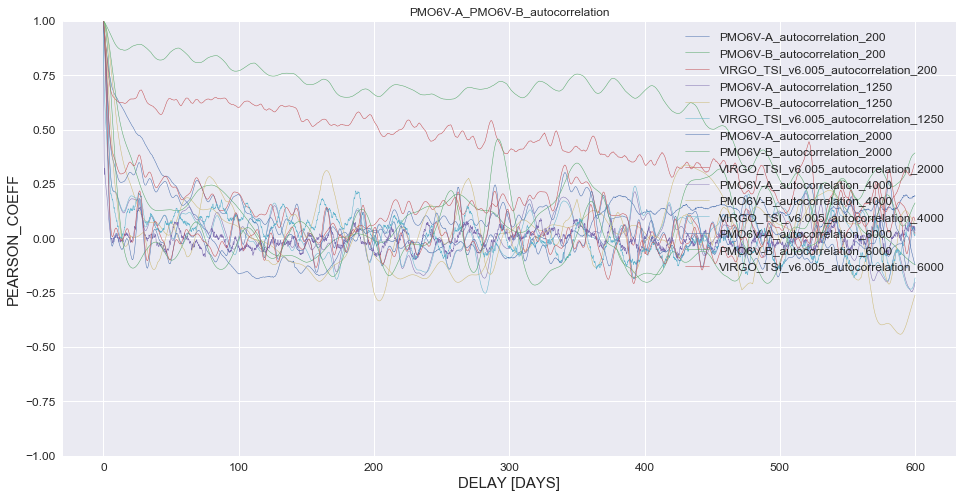

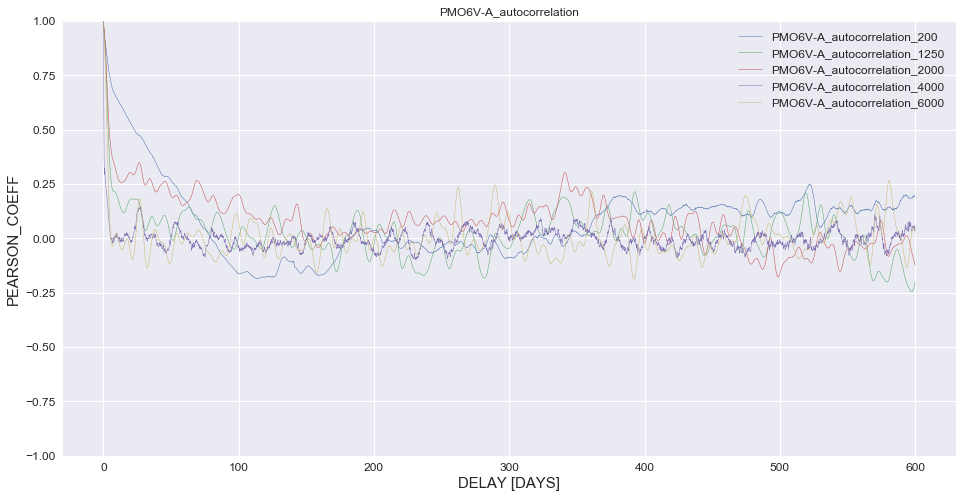

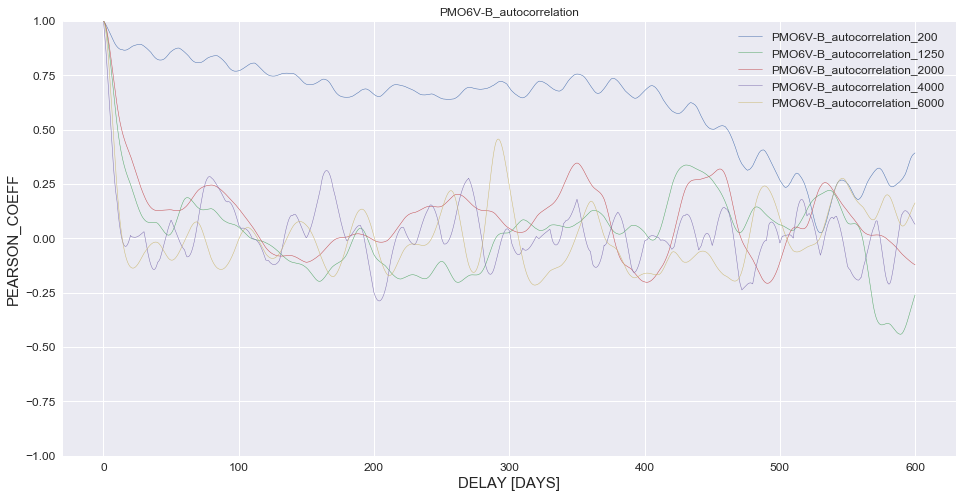

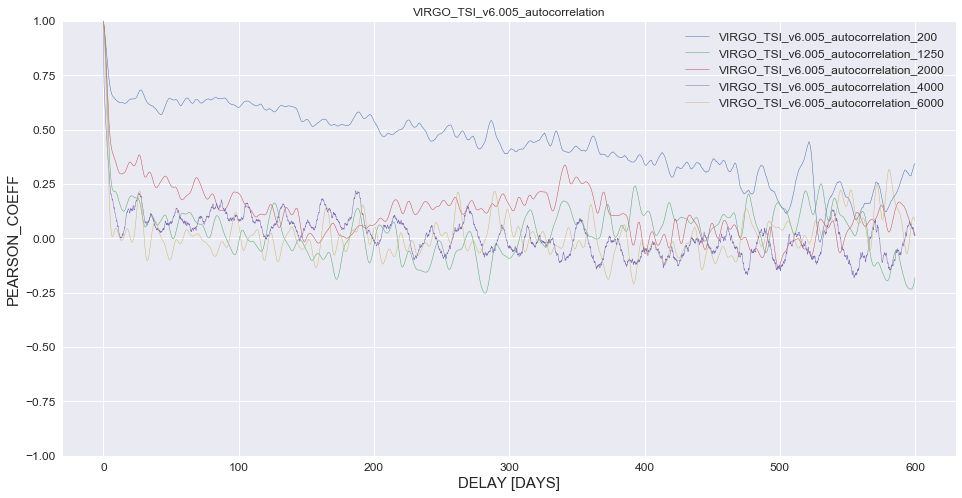

In [113]:
from scipy import interpolate
from scipy.optimize import curve_fit

t_min = np.max([other_t[0], base_sig.t_a_nn[0], base_sig.t_b_nn[0]])
t_max = np.min([other_t[-1], base_sig.t_a_nn[-1], base_sig.t_b_nn[-1]])

delay_window = 600
resampling_window = 1000
n_resampling_points = 10000

tau = resampling_window/(n_resampling_points-1)
n_lags = np.ceil(delay_window / tau).astype(int)

print("tau", tau)
print("n_lags", n_lags)

idx_delay = np.arange(0, n_lags, 1)
t_delay = idx_delay * tau

fourplets = []
fourplets_a = []
fourplets_b = []
fourplets_o = []

for t_min in [200, 1250, 2000, 4000, 6000]:
    t = np.linspace(t_min, t_min + resampling_window, n_resampling_points)
    print("t", t.shape)

    t_a, a = base_sig.t_a_nn, final_res.a_nn_corrected
    t_b, b = base_sig.t_b_nn, final_res.b_nn_corrected
    t_o, o = other_t, other_tsi

    if True:
        a = normalize(a, np.mean(a), np.std(a))
        b = normalize(b, np.mean(b), np.std(b))
        o = normalize(o, np.mean(o), np.std(o))

    if True:
        c_dev = 4
        clip_indices_a = np.multiply(np.greater_equal(a, -c_dev), np.less_equal(a, c_dev)).astype(np.bool).flatten()
        clip_indices_b = np.multiply(np.greater_equal(b, -c_dev), np.less_equal(b, c_dev)).astype(np.bool).flatten()
        clip_indices_o = np.multiply(np.greater_equal(o, -c_dev), np.less_equal(o, c_dev)).astype(np.bool).flatten()
        t_a, a = t_a[clip_indices_a], a[clip_indices_a]
        t_b, b = t_b[clip_indices_b], b[clip_indices_b]
        t_o, o = t_o[clip_indices_o], o[clip_indices_o]

    f_a = interpolate.interp1d(t_a, a)
    f_b = interpolate.interp1d(t_b, b)
    f_o = interpolate.interp1d(t_o, o)

    a, b, o = pd.Series(f_a(t)), pd.Series(f_b(t)), pd.Series(f_o(t))

    acorr_a, acorr_b, acorr_o = np.zeros(idx_delay.shape[0]), np.zeros(idx_delay.shape[0]), np.zeros(idx_delay.shape[0])
    # acov_a, acov_b, acov_o = np.zeros(idx_delay.shape[0]), np.zeros(idx_delay.shape[0]), np.zeros(idx_delay.shape[0])

    for idx, lag in enumerate(idx_delay):
        acorr_a[idx] = a.autocorr(lag=lag)
        acorr_b[idx] = b.autocorr(lag=lag)
        acorr_o[idx] = o.autocorr(lag=lag)

    #     acov_a[idx] = a.corr(a.iloc[::-1].shift(lag))
    #     acov_b[idx] = b.corr(b.iloc[::-1].shift(lag))
    #     acov_o[idx] = o.corr(o.iloc[::-1].shift(lag))

    fourplets.extend([
        (t_delay, acorr_a, f"{Const.A}_autocorrelation_{t_min}", False),
        (t_delay, acorr_b, f"{Const.B}_autocorrelation_{t_min}", False),
        (t_delay, acorr_o, f"VIRGO_TSI_v6.005_autocorrelation_{t_min}", False),
    ])

    fourplets_a.append((t_delay, acorr_a, f"{Const.A}_autocorrelation_{t_min}", False))
    fourplets_b.append((t_delay, acorr_b, f"{Const.B}_autocorrelation_{t_min}", False))
    fourplets_o.append((t_delay, acorr_o, f"VIRGO_TSI_v6.005_autocorrelation_{t_min}", False))


    visualizer.plot_signals(
    [
        (t_delay, acorr_a, f"{Const.A}_autocorrelation", False),
        (t_delay, acorr_b, f"{Const.B}_autocorrelation", False),
        (t_delay, acorr_o, f"VIRGO_TSI_v6.005_autocorrelation", False),
    ],
    None, f"{Const.A}_{Const.B}_autocorrelation",
    legend="upper right", x_label="DELAY [DAYS]", y_label="PEARSON_COEFF", y_lim=[-1, 1])
    
    visualizer.plot_signals(
    [
        (t, a, f"{Const.A}_resampled", False),
        (t, b, f"{Const.B}_resampled", False),
        (t, o, f"VIRGO_TSI_v6.005_resampled", False),
    ],
    None, f"{Const.A}_{Const.B}_autocorrelation", 
    legend="upper right", x_label=Const.DAY_UNIT, y_label=Const.TSI_UNIT)
    

visualizer.plot_signals(fourplets,
None, f"{Const.A}_{Const.B}_autocorrelation",
legend="upper right", x_label="DELAY [DAYS]", y_label="PEARSON_COEFF", y_lim=[-1, 1])

visualizer.plot_signals(fourplets_a,
None, f"{Const.A}_autocorrelation",
legend="upper right", x_label="DELAY [DAYS]", y_label="PEARSON_COEFF", y_lim=[-1, 1])

visualizer.plot_signals(fourplets_b,
None, f"{Const.B}_autocorrelation",
legend="upper right", x_label="DELAY [DAYS]", y_label="PEARSON_COEFF", y_lim=[-1, 1])

visualizer.plot_signals(fourplets_o,
None, f"VIRGO_TSI_v6.005_autocorrelation",
legend="upper right", x_label="DELAY [DAYS]", y_label="PEARSON_COEFF", y_lim=[-1, 1])

tau 0.1000100010001
n_lags 1500
t (10000,)


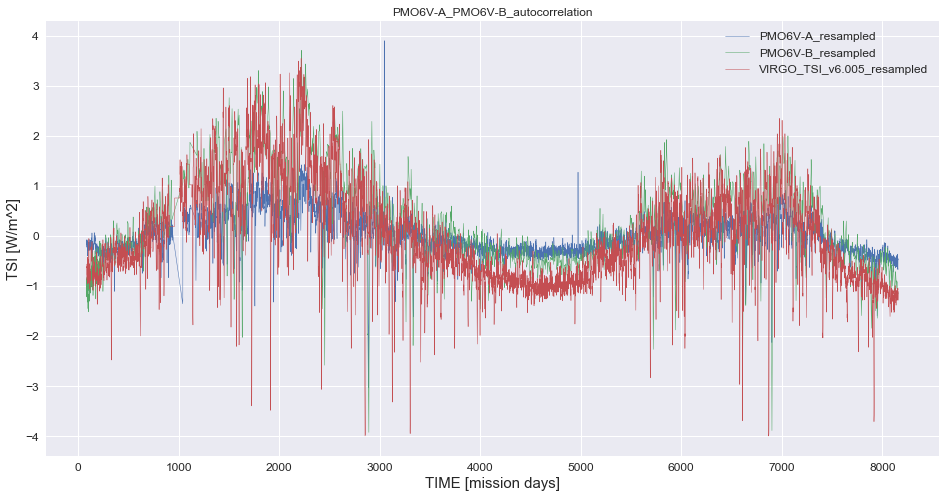

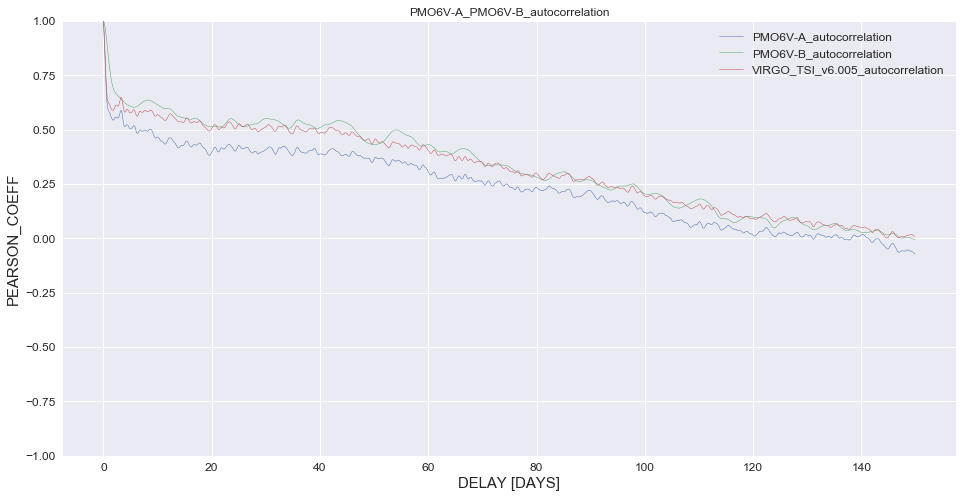

In [148]:
from scipy import interpolate
from scipy.optimize import curve_fit

t_min = np.max([other_t[0], base_sig.t_a_nn[0], base_sig.t_b_nn[0]])
t_max = np.min([other_t[-1], base_sig.t_a_nn[-1], base_sig.t_b_nn[-1]])

delay_window = 150
resampling_window = 1000
n_resampling_points = 10000

tau = resampling_window/(n_resampling_points-1)
n_lags = np.ceil(delay_window / tau).astype(int)

print("tau", tau)
print("n_lags", n_lags)

idx_delay = np.arange(0, n_lags, 1)
t_delay = idx_delay * tau

fourplets = []
fourplets_a = []
fourplets_b = []
fourplets_o = []

t = np.linspace(t_min, t_max, n_resampling_points)
print("t", t.shape)

t_a, a = base_sig.t_a_nn, final_res.a_nn_corrected
t_b, b = base_sig.t_b_nn, final_res.b_nn_corrected
t_o, o = other_t, other_tsi

if True:
    a = normalize(a, np.mean(a), np.std(a))
    b = normalize(b, np.mean(b), np.std(b))
    o = normalize(o, np.mean(o), np.std(o))

if True:
    c_dev = 4
    clip_indices_a = np.multiply(np.greater_equal(a, -c_dev), np.less_equal(a, c_dev)).astype(np.bool).flatten()
    clip_indices_b = np.multiply(np.greater_equal(b, -c_dev), np.less_equal(b, c_dev)).astype(np.bool).flatten()
    clip_indices_o = np.multiply(np.greater_equal(o, -c_dev), np.less_equal(o, c_dev)).astype(np.bool).flatten()
    t_a, a = t_a[clip_indices_a], a[clip_indices_a]
    t_b, b = t_b[clip_indices_b], b[clip_indices_b]
    t_o, o = t_o[clip_indices_o], o[clip_indices_o]

f_a = interpolate.interp1d(t_a, a)
f_b = interpolate.interp1d(t_b, b)
f_o = interpolate.interp1d(t_o, o)

a, b, o = pd.Series(f_a(t)), pd.Series(f_b(t)), pd.Series(f_o(t))

acorr_a, acorr_b, acorr_o = np.zeros(idx_delay.shape[0]), np.zeros(idx_delay.shape[0]), np.zeros(idx_delay.shape[0])

for idx, lag in enumerate(idx_delay):
    acorr_a[idx] = a.autocorr(lag=lag)
    acorr_b[idx] = b.autocorr(lag=lag)
    acorr_o[idx] = o.autocorr(lag=lag)

visualizer.plot_signals(
[
    (t, a, f"{Const.A}_resampled", False),
    (t, b, f"{Const.B}_resampled", False),
    (t, o, f"VIRGO_TSI_v6.005_resampled", False),
],
None, f"{Const.A}_{Const.B}_autocorrelation", 
legend="upper right", x_label=Const.DAY_UNIT, y_label=Const.TSI_UNIT)

visualizer.plot_signals(
[
    (t_delay, acorr_a, f"{Const.A}_autocorrelation", False),
    (t_delay, acorr_b, f"{Const.B}_autocorrelation", False),
    (t_delay, acorr_o, f"VIRGO_TSI_v6.005_autocorrelation", False),
],
None, f"{Const.A}_{Const.B}_autocorrelation",
legend="upper right", x_label="DELAY [DAYS]", y_label="PEARSON_COEFF", y_lim=[-1, 1])

In [146]:
def matern12(d, a0, a1):
    return a0 * np.exp(-d/a1)

def white(d, a0):
    return (d == 0) * a0

def periodic(d, a0, a1, a2):
    return a0 * np.exp(- np.square(np.sin(d / a1)) / a2)

def linear(d, a0, a1):
    return a0 + a1 * d

# def kernel(d, a0, a1, a2, a3, a4, a5):
#     return white(d, a0) + matern12(d, a1, a2) + periodic(d, a3, a4, a5)

def kernel(d, a0, a1, a2, a3, a4):
    return linear(d, a0, a1) +  periodic(d, a2, a3, a4)

popt_a, _ = curve_fit(kernel, t_delay, acorr_a, maxfev=10000)
popt_b, _ = curve_fit(kernel, t_delay, acorr_b, maxfev=10000)
popt_o, _ = curve_fit(kernel, t_delay, acorr_o, maxfev=10000)

print("a", popt_a)
print("b", popt_b)
print("o", popt_o)

k_a, k_b, k_o = kernel(t_delay, *popt_a), kernel(t_delay, *popt_b), kernel(t_delay, *popt_o)

visualizer.plot_signals(
[
    (t_delay, acorr_a, f"{Const.A}_autocorrelation", False),
#     (t_delay, acorr_b, f"{Const.B}_autocorrelation", False),
#     (t_delay, acorr_o, f"VIRGO_TSI_v6.005_autocorrelation", False),
#     (t_delay, k_a, "k_a", False), (t_delay, k_b, "k_b", False), (t_delay, k_o, "k_o", False)
],
None, f"{Const.A}_{Const.B}_autocorrelation_kernels",
legend="upper right", x_label="LAG", y_label="PEARSON_COEFF")

ValueError: operands could not be broadcast together with shapes (200,) (1500,) 

In [147]:
def matern12(d, a0, a1):
    return a0 * np.exp(-d/a1)

def white(d, a0):
    return (d == 0) * a0

def periodic(d, a0, a1, a2):
    return a0 * np.exp(- np.square(np.sin(d / a1)) / a2)

def linear(d, a0, a1):
    return a0 + a1 * d

def kernel(d, a0, a1, a2, a3, a4):
    return linear(d, a0, a1) +  periodic(d, a2, a3, a4)

start, end = 200, 400
t, x_a, x_b, x_o = t_delay[start:end], acorr_a[start:end], acorr_b[start:end], acorr_o[start:end]

popt_a, _ = curve_fit(kernel, t, x_a, maxfev=10000)
popt_b, _ = curve_fit(kernel, t, x_b, maxfev=10000)
popt_o, _ = curve_fit(kernel, t, x_o, maxfev=10000)

print("a", popt_a)
print("b", popt_b)
print("o", popt_o)

k_a, k_b, k_o = kernel(t, *popt_a), kernel(t, *popt_b), kernel(t, *popt_o)

visualizer.plot_signals(
[
    (t, x_a, f"{Const.A}_autocorrelation", False),
    (t, x_b, f"{Const.B}_autocorrelation", False),
    (t, x_o, f"VIRGO_TSI_v6.005_autocorrelation", False),
    (t, k_a, "k_a", False), (t, k_b, "k_b", False), (t, k_o, "k_o", False)
],
None, f"{Const.A}_{Const.B}_autocorrelation_kernels",
legend="upper right", x_label="LAG", y_label="PEARSON_COEFF")

ValueError: `ydata` must not be empty!

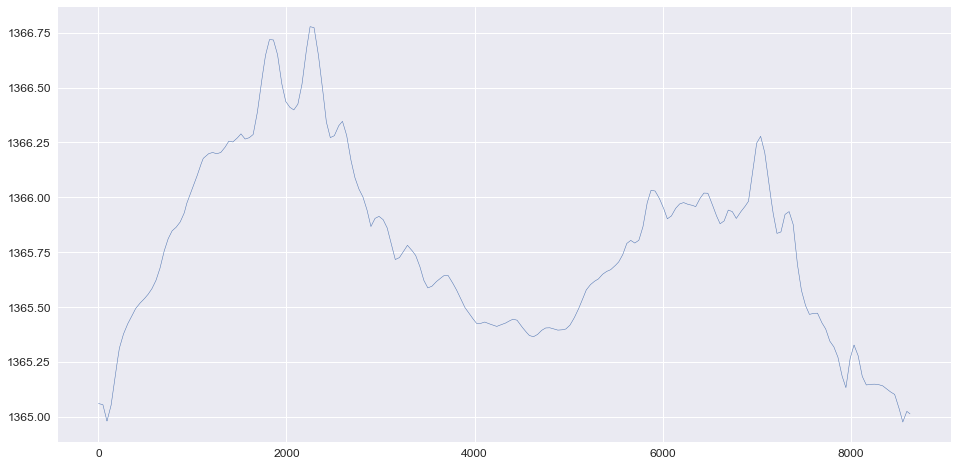

In [132]:
out_res.signal_daily_out
plt.plot(out_res.signal_daily_out)